<h3>Tokenizer Evaluation on HAR, Sex 

Compare classification of magnitude model to tokenized magnitude with various quantisations. 

In [1]:
# Configure GPU

import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True


/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set up

In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Compiled with CUDA:", torch.version.cuda)
print("GPU support enabled:", torch.backends.cuda.is_built())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.7.0+cu126
CUDA available: True
Compiled with CUDA: 12.6
GPU support enabled: True
Using device: cuda


Load data

In [3]:
import pandas as pd

#tokenized string for each participant - about a day of data. 
pid_tokens=pd.read_csv("/home/hrs675/Wearables_Tokenizer/data/pid_token_string_numbers.csv")

In [4]:
pid_tokens['pid'] = pid_tokens['pid'].str[:4]
pid_tokens.head()

,pid,token_string
0,P030,1 b 1 b 3 bb 4 b 3 bbb 1 bb 4 b 2 b 1 bb 4 bb...
1,P036,kjfgghhjlhhhihhighggjigheddddddcdefefeekkgjjhi...
2,P113,bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbcbbbebbbbb...
3,P048,cbb 2 gebbbb 1 bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
4,P099,1 c 1 cbbcbbbbbbccccccccccccccccccccccccccccc...


In [5]:
metadata= pd.read_csv("/data/UKBB/kyra/capture24/metadata.csv")

In [6]:
#combine meta data and token strings]
meta_tokens= pd.merge(metadata, pid_tokens, on='pid', how='inner')
meta_tokens.head()

,pid,age,sex,token_string
0,P001,38-52,F,bb 3 bbbbbbbbb 1 bbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
1,P002,30-37,F,cccbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
2,P003,30-37,F,bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
3,P004,53+,F,21 b 3 ebbbbbbbbbcbbbbbbbbbcbbbbbbbdgbbbbcbbb...
4,P005,38-52,F,cccccccccccccccccccccccccccccccccccccccccccccc...


In [7]:
# Save the combined meta_tokens DataFrame to CSV
meta_tokens.to_csv("/home/hrs675/Wearables_Tokenizer/data/meta_tokens.csv", index=False)

Train/ Test split

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tokenizers import Tokenizer
import numpy as np


In [9]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should be >= 1


True
3


In [10]:
# Your raw inputs
X = meta_tokens['token_string']
Y = meta_tokens['sex']

# Load your tokenizer
tokenizer = Tokenizer.from_file("/home/hrs675/Wearables_Tokenizer/Trained Tokenizers/trained_tokenizer_2.json")

def encode_token_string(tokenizer, s, max_len=512):
    ids = tokenizer.encode(s).ids
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

X_ids = [encode_token_string(tokenizer, s) for s in X]

# Encode labels (e.g., Male/Female -> 0/1)
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X_ids, Y_encoded, test_size=0.2, random_state=42)


In [11]:
class TokenSexDataset(Dataset):
    def __init__(self, X_token_ids, Y_sex):
        self.X = torch.tensor(X_token_ids, dtype=torch.long)
        self.Y = torch.tensor(Y_sex, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [12]:
class TransformerWithSex(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=4, num_layers=2, max_len=512, sex_emb_dim=16, num_classes=2):
        super().__init__()

        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, max_len, emb_dim))
        self.sex_emb = nn.Embedding(2, sex_emb_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Sequential(
            nn.Linear(emb_dim + sex_emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, token_ids, sex):
        x = self.token_emb(token_ids) + self.pos_emb[:, :token_ids.size(1), :]
        x = self.transformer(x)
        x_pooled = x.mean(dim=1)
        sex_e = self.sex_emb(sex)
        x_combined = torch.cat([x_pooled, sex_e], dim=1)
        return self.fc(x_combined)


In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [14]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [15]:
# Dataloaders
train_loader = DataLoader(TokenSexDataset(X_train, Y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TokenSexDataset(X_test, Y_test), batch_size=32)

# Model, loss, optimizer
model = TransformerWithSex(vocab_size=tokenizer.get_vocab_size()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/home/hrs675/Wearables_Tokenizer/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [16]:
train_losses = []
train_accuracies = []
test_accuracies = []
epochs = 30

In [17]:

for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_preds, train_labels = [], []

    for token_ids_batch, sex_batch in train_loader:
        token_ids_batch = token_ids_batch.to(device)
        sex_batch = sex_batch.to(device)

        optimizer.zero_grad()
        outputs = model(token_ids_batch, sex_batch)
        loss = criterion(outputs, sex_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(sex_batch.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)
    train_losses.append(total_loss)

    # Evaluation
    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for token_ids_batch, sex_batch in test_loader:
            token_ids_batch = token_ids_batch.to(device)
            sex_batch = sex_batch.to(device)
            outputs = model(token_ids_batch, sex_batch)
            preds = torch.argmax(outputs, dim=1)

            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(sex_batch.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


Epoch 1/30 | Loss: 2.4308 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 2/30 | Loss: 2.1374 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 3/30 | Loss: 2.0896 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 4/30 | Loss: 2.0325 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 5/30 | Loss: 1.9866 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 6/30 | Loss: 1.9531 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 7/30 | Loss: 1.9551 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 8/30 | Loss: 1.8903 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 9/30 | Loss: 1.8723 | Train Acc: 0.6667 | Test Acc: 0.6129
Epoch 10/30 | Loss: 1.8333 | Train Acc: 0.7417 | Test Acc: 0.6452
Epoch 11/30 | Loss: 1.7960 | Train Acc: 0.6917 | Test Acc: 0.6129
Epoch 12/30 | Loss: 1.7695 | Train Acc: 0.6750 | Test Acc: 0.6129
Epoch 13/30 | Loss: 1.7472 | Train Acc: 0.6750 | Test Acc: 0.6129
Epoch 14/30 | Loss: 1.7058 | Train Acc: 0.7333 | Test Acc: 0.9677
Epoch 15/30 | Loss: 1.6757 | Train Acc: 0.9833 | Test Acc: 1.0000
Epoch 16/30 | Loss:

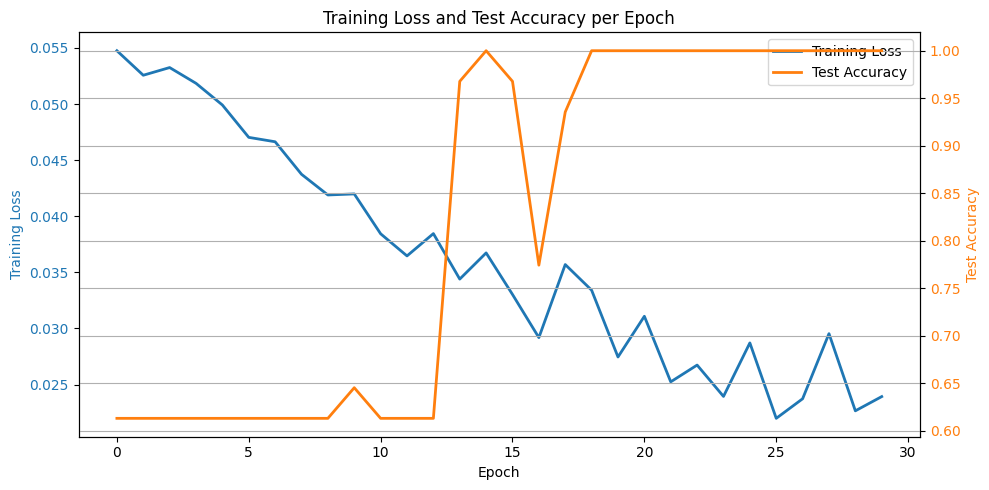

In [32]:
# ...existing code...

plt.figure(figsize=(10, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Training Loss (left y-axis)
ax1.plot(train_losses, label='Training Loss', color='tab:blue', linewidth=2)
ax1.set_ylabel('Training Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Test Accuracy (right y-axis)
ax2.plot(test_accuracies, label='Test Accuracy', color='tab:orange', linewidth=2)
ax2.set_ylabel('Test Accuracy', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.set_xlabel('Epoch')
plt.title('Training Loss and Test Accuracy per Epoch')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd

# Decode numeric labels back to original "Male"/"Female" labels
actual_labels = le.inverse_transform(test_labels)
predicted_labels = le.inverse_transform(test_preds)

# Create DataFrame to show results
results_df = pd.DataFrame({
    "Actual Sex": actual_labels,
    "Predicted Sex": predicted_labels
})

# Display first 20 rows (or all)
print(results_df.head(25))  # or .to_string(index=False) for cleaner output


   Actual Sex Predicted Sex
0           F             F
1           F             F
2           M             M
3           M             M
4           M             M
5           M             M
6           F             F
7           F             F
8           F             F
9           F             F
10          F             F
11          M             M
12          F             F
13          F             F
14          M             M
15          F             F
16          F             F
17          F             F
18          M             M
19          M             M
20          M             M
21          F             F
22          F             F
23          F             F
24          F             F


<Figure size 600x600 with 0 Axes>

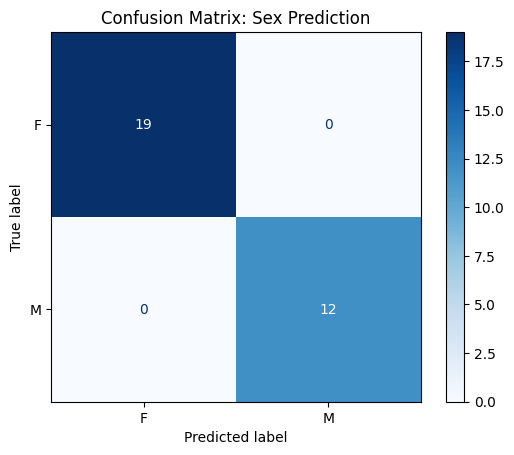

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=le.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Sex Prediction")
plt.show()

In [20]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")

# Example usage:
count_parameters(model)


Total parameters: 1,398,434
Trainable parameters: 1,398,434


Cross Validation

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Set folds
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

X_ids = np.array(X_ids)
Y_encoded = np.array(Y_encoded)

fold_accuracies = []


In [22]:
len(X_ids), len(Y_encoded), len(X_train), len(X_test)

(151, 151, 120, 31)

In [23]:
for fold, (train_index, test_index) in enumerate(skf.split(X_ids, Y_encoded)):
    print(f"\n--- Fold {fold+1} ---")

    # Split into training and testing sets
    X_train, X_test = X_ids[train_index], X_ids[test_index]
    Y_train, Y_test = Y_encoded[train_index], Y_encoded[test_index]

    # Dataloaders
    train_loader = DataLoader(TokenSexDataset(X_train, Y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(TokenSexDataset(X_test, Y_test), batch_size=32)

    # Initialize new model each fold
    model = TransformerWithSex(vocab_size=tokenizer.get_vocab_size()).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(15):  # You can increase this
        model.train()
        for token_ids_batch, sex_batch in train_loader:
            token_ids_batch = token_ids_batch.to(device)
            sex_batch = sex_batch.to(device)

            optimizer.zero_grad()
            outputs = model(token_ids_batch, sex_batch)
            loss = criterion(outputs, sex_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for token_ids_batch, sex_batch in test_loader:
            token_ids_batch = token_ids_batch.to(device)
            sex_batch = sex_batch.to(device)
            outputs = model(token_ids_batch, sex_batch)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(sex_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")



--- Fold 1 ---
Fold 1 Accuracy: 1.0000

--- Fold 2 ---
Fold 2 Accuracy: 1.0000

--- Fold 3 ---
Fold 3 Accuracy: 1.0000

--- Fold 4 ---
Fold 4 Accuracy: 0.9000

--- Fold 5 ---
Fold 5 Accuracy: 0.7667


In [24]:
print(f"\nCross-Validation Accuracy (mean ± std): {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")


Cross-Validation Accuracy (mean ± std): 0.9333 ± 0.0919



--- Fold 1/5 ---
Total parameters: 1,398,434
Trainable parameters: 1,398,434
Epoch 1: Validation Accuracy = 0.6818
Epoch 2: Validation Accuracy = 0.6364
Epoch 3: Validation Accuracy = 0.6364
Epoch 4: Validation Accuracy = 0.6364
Epoch 5: Validation Accuracy = 0.6364
Epoch 6: Validation Accuracy = 0.6364
Epoch 7: Validation Accuracy = 0.6364
Epoch 8: Validation Accuracy = 0.6364
Early stopping triggered.
Fold 1 Test Accuracy = 0.6452

--- Fold 2/5 ---
Total parameters: 1,398,434
Trainable parameters: 1,398,434
Epoch 1: Validation Accuracy = 0.6364
Epoch 2: Validation Accuracy = 0.6364
Epoch 3: Validation Accuracy = 0.6364
Epoch 4: Validation Accuracy = 0.6364
Epoch 5: Validation Accuracy = 0.6364
Epoch 6: Validation Accuracy = 0.6364
Epoch 7: Validation Accuracy = 0.6364
Epoch 8: Validation Accuracy = 0.6364
Early stopping triggered.
Fold 2 Test Accuracy = 0.6667

--- Fold 3/5 ---
Total parameters: 1,398,434
Trainable parameters: 1,398,434
Epoch 1: Validation Accuracy = 0.6364
Epoch 2:

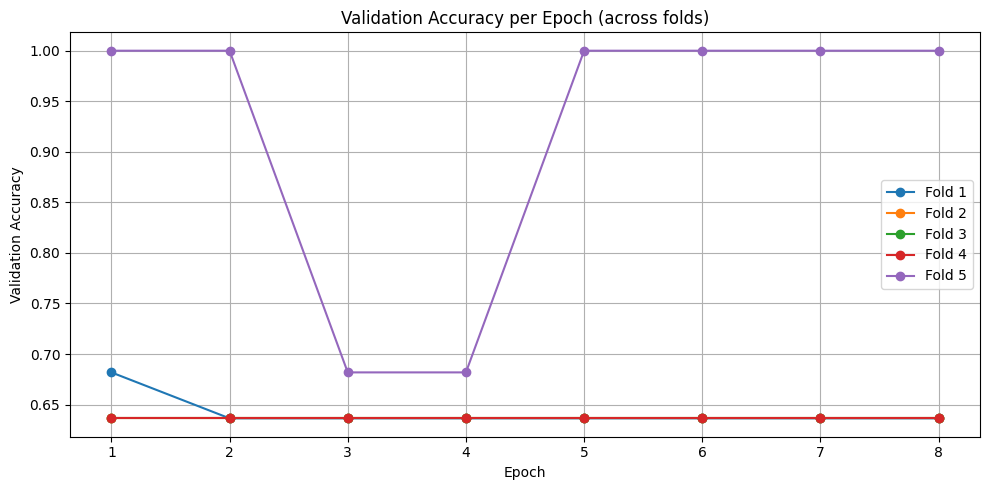

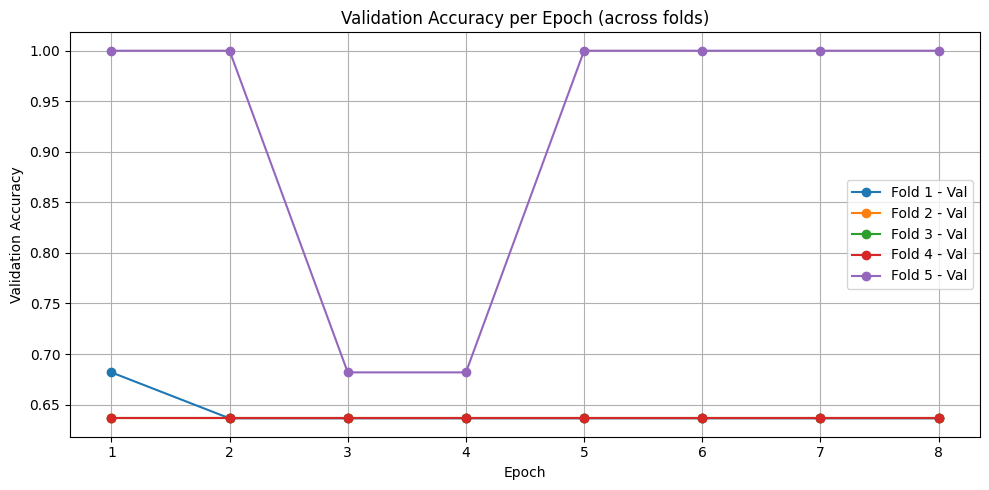

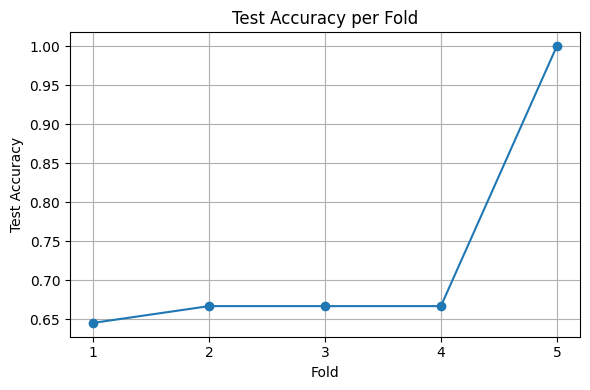

Average Test Accuracy across folds: 0.7290 ± 0.1357


In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset

# --- Define Dataset Class ---
class TokenSexDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# --- Define Model ---
class TransformerWithSex(torch.nn.Module):
    def __init__(self, vocab_size, emb_dim=128, nhead=4, num_layers=2, max_len=512, sex_emb_dim=16, num_classes=2):
        super().__init__()
        self.token_emb = torch.nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, max_len, emb_dim))
        self.sex_emb = torch.nn.Embedding(2, sex_emb_dim)
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, batch_first=True)
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(emb_dim + sex_emb_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, num_classes)
        )

    def forward(self, token_ids, sex):
        x = self.token_emb(token_ids) + self.pos_emb[:, :token_ids.size(1), :]
        x = self.transformer(x)
        x_pooled = x.mean(dim=1)
        sex_e = self.sex_emb(sex)
        x_combined = torch.cat([x_pooled, sex_e], dim=1)
        return self.fc(x_combined)

# --- Count Parameters ---
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")

# --- Assume X_ids and Y_encoded already exist ---
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

X_ids = np.array(X_ids)
Y_encoded = np.array(Y_encoded)

val_accuracy_history = []
fold_results = []

for fold, (trainval_idx, test_idx) in enumerate(skf.split(X_ids, Y_encoded)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    X_trainval, X_test = X_ids[trainval_idx], X_ids[test_idx]
    Y_trainval, Y_test = Y_encoded[trainval_idx], Y_encoded[test_idx]

    X_train, X_val, Y_train, Y_val = train_test_split(
        X_trainval, Y_trainval, test_size=0.1765, random_state=42, stratify=Y_trainval
    )  # 0.1765 = 0.15 / 0.85 to achieve 70/15/15 split

    train_loader = DataLoader(TokenSexDataset(X_train, Y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TokenSexDataset(X_val, Y_val), batch_size=32)
    test_loader = DataLoader(TokenSexDataset(X_test, Y_test), batch_size=32)

    model = TransformerWithSex(vocab_size=tokenizer.get_vocab_size()).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    count_parameters(model)

    best_val_acc = 0
    best_model_state = None
    val_accs_this_fold = []

    # Early stopping setup
    patience = 7
    epochs_without_improvement = 0
    max_epochs = 50

    for epoch in range(max_epochs):
        model.train()
        for token_ids_batch, sex_batch in train_loader:
            token_ids_batch = token_ids_batch.to(device)
            sex_batch = sex_batch.to(device)

            optimizer.zero_grad()
            outputs = model(token_ids_batch, sex_batch)
            loss = criterion(outputs, sex_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for token_ids_batch, sex_batch in val_loader:
                token_ids_batch = token_ids_batch.to(device)
                sex_batch = sex_batch.to(device)
                outputs = model(token_ids_batch, sex_batch)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(sex_batch.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_accs_this_fold.append(val_acc)
        print(f"Epoch {epoch+1}: Validation Accuracy = {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    val_accuracy_history.append(val_accs_this_fold)

    # Load best model and evaluate on test set
    model.load_state_dict(best_model_state)
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for token_ids_batch, sex_batch in test_loader:
            token_ids_batch = token_ids_batch.to(device)
            sex_batch = sex_batch.to(device)
            outputs = model(token_ids_batch, sex_batch)
            preds = torch.argmax(outputs, dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(sex_batch.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    fold_results.append(test_acc)
    print(f"Fold {fold+1} Test Accuracy = {test_acc:.4f}")

# --- Plot validation accuracy per epoch ---
plt.figure(figsize=(10, 5))
for i, val_accs in enumerate(val_accuracy_history):
    plt.plot(range(1, len(val_accs)+1), val_accs, marker='o', label=f"Fold {i+1}")

plt.title("Validation Accuracy per Epoch (across folds)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot validation accuracy per epoch ---
plt.figure(figsize=(10, 5))
for i, val_accs in enumerate(val_accuracy_history):
    plt.plot(range(1, len(val_accs)+1), val_accs, marker='o', label=f"Fold {i+1} - Val")

plt.title("Validation Accuracy per Epoch (across folds)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot test accuracy per fold ---
plt.figure(figsize=(6, 4))
plt.plot(range(1, k_folds + 1), fold_results, marker='o', label="Test Accuracy")
plt.title("Test Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Test Accuracy")
plt.xticks(range(1, k_folds + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Final summary ---
print(f"Average Test Accuracy across folds: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")
